In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Flatten, concatenate, Dense, Dropout, Lambda
from keras.metrics import Precision, Recall, AUC
from keras.callbacks import EarlyStopping, ModelCheckpoint

import tensorflow as tf 
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.optimizers import Adam, SGD

In [2]:
df = pd.read_csv('masterdata.csv')

In [3]:
df = df.drop(columns = ['Unnamed: 0', 'category', 'label', 'text_', 'lang', 'cleaned_text'])

In [4]:
df.head()

,rating,review_length,end_with_punc,clean_text,target,category_Books_5,category_Clothing_Shoes_and_Jewelry_5,category_Electronics_5,category_Home_and_Kitchen_5,category_Kindle_Store_5,category_Movies_and_TV_5,category_Pet_Supplies_5,category_Sports_and_Outdoors_5,category_Tools_and_Home_Improvement_5,category_Toys_and_Games_5
0,5.0,12,0,love this well made sturdy and very comfortabl...,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.0,16,0,love it a great upgrade from the original ive ...,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.0,14,1,this pillow saved my back i love the look and ...,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,17,0,missing information on how to use it but it is...,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,18,0,very nice set good quality we have had the set...,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
df.review_length.median()

39.0

In [11]:
df_short = df[df.review_length<=39]
df_long = df[df.review_length>39]

print(len(df_short))
print(len(df_long))

20513
19849


### Short Reviews

In [12]:
from sklearn.model_selection import train_test_split

X=df_short.drop('target', axis=1)
y=df_short.target.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [13]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train['clean_text'])

X_train_text = tokenizer.texts_to_sequences(X_train['clean_text'])
X_test_text = tokenizer.texts_to_sequences(X_test['clean_text'])

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

In [14]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 100

X_train_text = pad_sequences(X_train_text, padding='post', maxlen=maxlen)
X_test_text = pad_sequences(X_test_text, padding='post', maxlen=maxlen)

In [15]:
X_train_num = X_train.drop(columns=['clean_text']) # drop the original clean_text textual data
X_test_num = X_test.drop(columns=['clean_text'])

In [16]:
print(X_train_text.shape)
print(X_train_num.shape)

(16410, 100)
(16410, 13)


In [17]:
X_train_concat = np.hstack((X_train_text, X_train_num.to_numpy()))
X_test_concat = np.hstack((X_test_text, X_test_num.to_numpy()))

In [18]:
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [19]:
emb_matrix = create_embedding_matrix("glove.6B.100d.txt", tokenizer.word_index, 100)

combi_input = Input((113,))
text_input = Lambda(lambda x: x[:, :100])(combi_input)
num_input = Lambda(lambda x: x[:, 100:])(combi_input)
emb = (Embedding(input_dim=vocab_size, 
                output_dim=100, 
                weights=[emb_matrix], 
                input_length=100,
                trainable=True))(text_input)

text_output = Conv1D(128, 7)(emb)
text_output = GlobalMaxPooling1D()(text_output)
concat = concatenate([text_output, num_input])

dropout1 = Dropout(0.3)(concat)
dense1 = Dense(32, activation='relu')(dropout1)
dropout2 = Dropout(0.3)(dense1)
dense2 = Dense(16, activation='relu')(dropout2)                     
dropout3 = Dropout(0.3)(dense2)     
output = Dense(1, activation='sigmoid')(dropout3)

CNN = Model(inputs=[combi_input], outputs=[output])
CNN.compile(loss='binary_crossentropy',
            optimizer=Adam(0.001),
            metrics=['accuracy', AUC(name='auc'), Precision(name='precision') , Recall(name='recall')])
CNN.summary()

es = EarlyStopping(monitor='val_loss', 
               mode='min', 
               patience=10)

mc = ModelCheckpoint('CNN_short.hdf5', 
                 monitor='val_loss',
                 mode='min',
                 verbose=1, 
                 save_best_only=True)
callbacks = [es, mc]

history = CNN.fit(X_train_concat, y_train,
                    epochs=50,
                    verbose=2,
                    validation_split=0.2,
                    batch_size=64,
                 callbacks = callbacks)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 113)]        0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 100)          0           input_1[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 100)     1349900     lambda[0][0]                     
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 94, 128)      89728       embedding[0][0]                  
______________________________________________________________________________________________

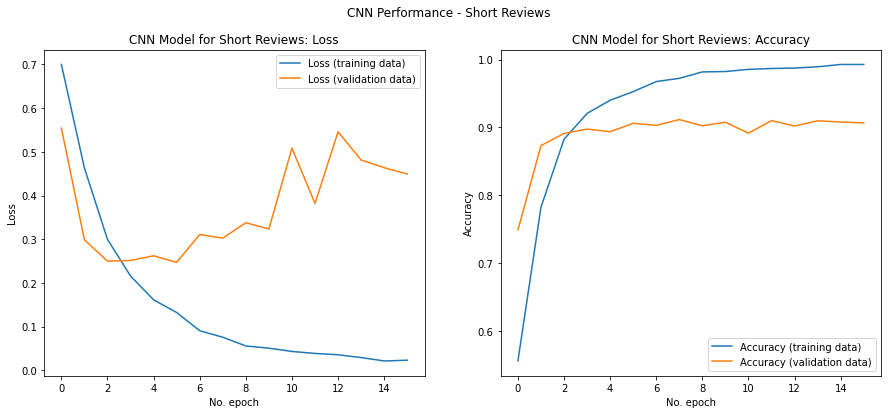

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('CNN Performance - Short Reviews')

ax1.plot(history.history['loss'], label='Loss (training data)')
ax1.plot(history.history['val_loss'], label='Loss (validation data)')
ax1.set_title('CNN Model for Short Reviews: Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('No. epoch')
ax1.legend(loc="upper right")

ax2.plot(history.history['accuracy'], label='Accuracy (training data)')
ax2.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
ax2.set_title('CNN Model for Short Reviews: Accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('No. epoch')
ax2.legend(loc="lower right")

In [21]:
model_short = load_model('CNN_short.hdf5')

loss, accuracy, precision, recall, auc = model_short.evaluate(X_train_concat, y_train, verbose=False)
print("Training Accuracy:  {:.4f}%".format(accuracy*100))
print("Precisiony: {:.4f}%".format(precision*100))
print("Recall: {:.4f}%".format(recall*100))
f1 = 2*(precision*recall)/(precision+recall)
print("F1 Score: {:.4f}%".format(f1*100))
print("Area under Curve: {:.4f}%".format(auc*100))

Training Accuracy:  96.2645%
Precisiony: 99.3952%
Recall: 97.9482%
F1 Score: 98.6664%
Area under Curve: 95.0182%


In [22]:
loss, accuracy, precision, recall, auc = model_short.evaluate(X_test_concat, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}%".format(accuracy*100))
print("Precisiony: {:.4f}%".format(precision*100))
print("Recall: {:.4f}%".format(recall*100))
f1 = 2*(precision*recall)/(precision+recall)
print("F1 Score: {:.4f}%".format(f1*100))
print("Area under Curve: {:.4f}%".format(auc*100))

Testing Accuracy:  90.2998%
Precisiony: 96.5273%
Recall: 92.6158%
F1 Score: 94.5311%
Area under Curve: 88.6784%


### Long Reviews

In [23]:
from sklearn.model_selection import train_test_split

X=df_long.drop('target', axis=1)
y=df_long.target.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [24]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train['clean_text'])

X_train_text = tokenizer.texts_to_sequences(X_train['clean_text'])
X_test_text = tokenizer.texts_to_sequences(X_test['clean_text'])

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

In [25]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 100

X_train_text = pad_sequences(X_train_text, padding='post', maxlen=maxlen)
X_test_text = pad_sequences(X_test_text, padding='post', maxlen=maxlen)

In [26]:
X_train_num = X_train.drop(columns=['clean_text']) # drop the original clean_text textual data
X_test_num = X_test.drop(columns=['clean_text'])

In [27]:
print(X_train_text.shape)
print(X_train_num.shape)

(15879, 100)
(15879, 13)


In [29]:
X_train_concat = np.hstack((X_train_text, X_train_num.to_numpy()))
X_test_concat = np.hstack((X_test_text, X_test_num.to_numpy()))

In [30]:
emb_matrix = create_embedding_matrix("glove.6B.100d.txt", tokenizer.word_index, 100)

combi_input = Input((113,))
text_input = Lambda(lambda x: x[:, :100])(combi_input)
num_input = Lambda(lambda x: x[:, 100:])(combi_input)
emb = (Embedding(input_dim=vocab_size, 
                output_dim=100, 
                weights=[emb_matrix], 
                input_length=100,
                trainable=True))(text_input)

text_output = Conv1D(128, 7)(emb)
text_output = GlobalMaxPooling1D()(text_output)
concat = concatenate([text_output, num_input])

dropout1 = Dropout(0.3)(concat)
dense1 = Dense(32, activation='relu')(dropout1)
dropout2 = Dropout(0.3)(dense1)
dense2 = Dense(16, activation='relu')(dropout2)                     
dropout3 = Dropout(0.3)(dense2)     
output = Dense(1, activation='sigmoid')(dropout3)

CNN = Model(inputs=[combi_input], outputs=[output])
CNN.compile(loss='binary_crossentropy',
            optimizer=Adam(0.001),
            metrics=['accuracy', AUC(name='auc'), Precision(name='precision') , Recall(name='recall')])
CNN.summary()

es = EarlyStopping(monitor='val_loss', 
               mode='min', 
               patience=10)

mc = ModelCheckpoint('CNN_long.hdf5', 
                 monitor='val_loss',
                 mode='min',
                 verbose=1, 
                 save_best_only=True)
callbacks = [es, mc]

history = CNN.fit(X_train_concat, y_train,
                    epochs=50,
                    verbose=2,
                    validation_split=0.2,
                    batch_size=64,
                 callbacks = callbacks)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 113)]        0                                            
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 100)          0           input_3[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 100, 100)     3514500     lambda_4[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 94, 128)      89728       embedding_2[0][0]                
____________________________________________________________________________________________

199/199 - 7s - loss: 0.0108 - accuracy: 0.9969 - auc: 0.9996 - precision: 0.9968 - recall: 0.9966 - val_loss: 0.3593 - val_accuracy: 0.9512 - val_auc: 0.9729 - val_precision: 0.9239 - val_recall: 0.9739

Epoch 00019: val_loss did not improve from 0.13782


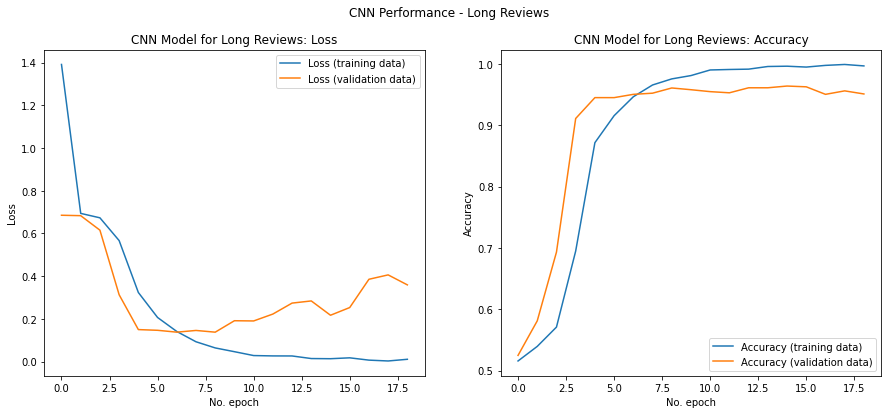

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('CNN Performance - Long Reviews')

ax1.plot(history.history['loss'], label='Loss (training data)')
ax1.plot(history.history['val_loss'], label='Loss (validation data)')
ax1.set_title('CNN Model for Long Reviews: Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('No. epoch')
ax1.legend(loc="upper right")

ax2.plot(history.history['accuracy'], label='Accuracy (training data)')
ax2.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
ax2.set_title('CNN Model for Long Reviews: Accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('No. epoch')
ax2.legend(loc="lower right")

In [32]:
model = load_model('CNN_long.hdf5')

loss, accuracy, precision, recall, auc = model.evaluate(X_train_concat, y_train, verbose=False)
print("Training Accuracy:  {:.4f}%".format(accuracy*100))
print("Precisiony: {:.4f}%".format(precision*100))
print("Recall: {:.4f}%".format(recall*100))
f1 = 2*(precision*recall)/(precision+recall)
print("F1 Score: {:.4f}%".format(f1*100))
print("Area under Curve: {:.4f}%".format(auc*100))

Training Accuracy:  99.0743%
Precisiony: 99.8095%
Recall: 98.9303%
F1 Score: 99.3679%
Area under Curve: 99.0778%


In [33]:
loss, accuracy, precision, recall, auc = model.evaluate(X_test_concat, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}%".format(accuracy*100))
print("Precisiony: {:.4f}%".format(precision*100))
print("Recall: {:.4f}%".format(recall*100))
f1 = 2*(precision*recall)/(precision+recall)
print("F1 Score: {:.4f}%".format(f1*100))
print("Area under Curve: {:.4f}%".format(auc*100))

Testing Accuracy:  96.5995%
Precisiony: 99.0973%
Recall: 95.8064%
F1 Score: 97.4241%
Area under Curve: 96.9005%
